## Add Caching Layer for Xarray Dataset

In [1]:
import pickle
from typing import Any, Callable, List, Optional

import attr
import xarray
from morecantile import TileMatrixSet
from rio_tiler.constants import WEB_MERCATOR_TMS
from rio_tiler.io.xarray import XarrayReader

from titiler.xarray.io import xarray_open_dataset, get_variable

from diskcache import Cache

cache_client = Cache()


@attr.s
class CustomReader(XarrayReader):
    """Reader: Open Zarr file and access DataArray."""

    src_path: str = attr.ib()
    variable: str = attr.ib()

    # xarray.Dataset options
    opener: Callable[..., xarray.Dataset] = attr.ib(default=xarray_open_dataset)

    group: Optional[Any] = attr.ib(default=None)
    decode_times: bool = attr.ib(default=False)

    # xarray.DataArray options
    sel: Optional[List[str]] = attr.ib(default=None)
    method: Optional[str] = attr.ib(default=None)

    tms: TileMatrixSet = attr.ib(default=WEB_MERCATOR_TMS)

    ds: xarray.Dataset = attr.ib(init=False)
    input: xarray.DataArray = attr.ib(init=False)

    _dims: List = attr.ib(init=False, factory=list)

    def __attrs_post_init__(self):
        """Set bounds and CRS."""
        ds = None
        # Generate cache key and attempt to fetch the dataset from cache
        cache_key = f"{self.src_path}_group:{self.group}_time:{self.decode_times}"
        data_bytes = cache_client.get(cache_key)
        if data_bytes:
            print(f"Found dataset in Cache {cache_key}")
            ds = pickle.loads(data_bytes)

        self.ds = ds or self.opener(
            self.src_path,
            group=self.group,
            decode_times=self.decode_times,
        )
        if not ds:
            # Serialize the dataset to bytes using pickle
            cache_key = f"{self.src_path}_group:{self.group}_time:{self.decode_times}"
            data_bytes = pickle.dumps(self.ds)
            print(f"Adding dataset in Cache: {cache_key}")
            cache_client.set(cache_key, data_bytes, tag="data", expire=300)

        self.input = get_variable(
            self.ds,
            self.variable,
            sel=self.sel,
            method=self.method,
        )
        super().__attrs_post_init__()

Found dataset in Cache ../tests/fixtures/dataset_2d.nc_group:None_time:False
<xarray.Dataset> Size: 16MB
Dimensions:  (x: 2000, y: 1000)
Coordinates:
  * x        (x) float64 16kB -170.0 -169.8 -169.7 -169.5 ... 169.5 169.7 169.8
  * y        (y) float64 8kB -80.0 -79.84 -79.68 -79.52 ... 79.52 79.68 79.84
Data variables:
    dataset  (y, x) float64 16MB ...


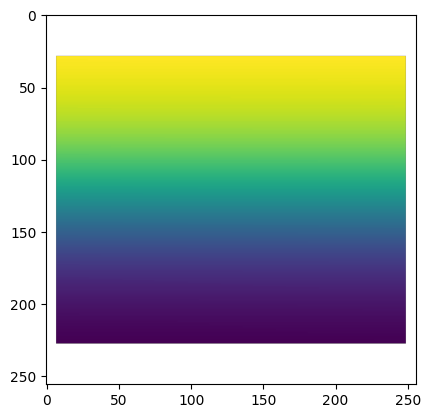

In [3]:
import matplotlib.pyplot as plt

with CustomReader("../tests/fixtures/dataset_2d.nc", "dataset") as src:
    print(src.ds)
    tile = src.tms.tile(src.bounds[0], src.bounds[1], src.minzoom)
    img = src.tile(*tile)

plt.imshow(img.data_as_image())